# Anomaly detection with n-sigma on z-score

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
import sys
sys.path.append("../")

from meltria import loader

In [4]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

from meltria.priorknowledge.priorknowledge import SockShopKnowledge

sockshop_pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [5]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    dataset_id=SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [6]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-cpu-hog", "orders-db")][1]
print(record.chaos_case_full())
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    # data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape, record.chaos_case_file()

orders-db/pod-cpu-hog/9n6mf-1


((180, 183),
 '2023-02-17-argowf-chaos-9n6mf-orders-db_pod-cpu-hog_1.json of orders-db/pod-cpu-hog')

In [16]:
import numpy as np
import scipy.stats

COEFF = scipy.stats.norm.ppf(0.75) - scipy.stats.norm.ppf(0.25)

def zscore_nsigma(train: np.ndarray, test: np.ndarray, n_sigmas: float = 3.0) -> tuple[np.ndarray, np.ndarray]:
    mu, sigma = np.mean(train), np.std(train)
    if sigma == 0.0:
        sigma = 1.0
    scores = np.abs((test - mu) / sigma)
    anomalies = test[scores > n_sigmas]
    return anomalies, scores

def zscore_nsigma_cause_rank(train: np.ndarray, test: np.ndarray, k: float) -> tuple[bool, np.ndarray]:
    mu, sigma = np.mean(train), np.std(train)
    if sigma == .0:
        sigma = 0.0001
    scores = np.abs((test - mu) / sigma)
    s_x: float = np.max(scores, axis=0)
    alpha_x: float = .0 if s_x < k else np.log1p(s_x)
    return alpha_x > .0, np.log1p(scores)


def robust_zscore_nsigma(
    train: np.ndarray, test: np.ndarray, test_start_time: int, n_sigmas: float = 3.0
) -> tuple[np.ndarray, np.ndarray]:
    iqr = np.quantile(train, 0.75) - np.quantile(train, 0.25)
    niqr = iqr / COEFF
    median = np.median(train)
    scores = np.abs(test - median)
    anomalies = test[scores > niqr * n_sigmas]
    return anomalies, scores


def detect_anomalies_with_zscore_nsigma(
    x: np.ndarray,
    anomalous_start_idx: int,
    n_sigmas: float = 3.0,
    robust: bool = False,
) -> tuple[bool, float]:
    test_start_idx = x.shape[0] - (anomalous_start_idx + 1)
    train, test = x[:test_start_idx], x[test_start_idx:]
    if robust:
        alarms, scores = robust_zscore_nsigma(train, test, test_start_idx, n_sigmas)
    else:
        alarms, scores = zscore_nsigma(train, test, n_sigmas)
    return alarms.size > 0, scores.max()


def detect_anomalies_with_zscore_nsigma_cause_rank(
    x: np.ndarray,
    anomalous_start_idx: int,
    k: float = 1.0,
) -> tuple[bool, np.ndarray]:
    test_start_idx = x.shape[0] - (anomalous_start_idx + 1)
    train, test = x[:test_start_idx], x[test_start_idx:]
    return zscore_nsigma_cause_rank(train, test, k)


In [17]:
# iterate dataset and detect anomalies
from joblib import Parallel, delayed

def _detect(x, label, anomalous_start_idx):
    is_anomaly, scores = detect_anomalies_with_zscore_nsigma_cause_rank(x, anomalous_start_idx=anomalous_start_idx, k=2.0)
    return (label, is_anomaly, x)

results: list[tuple[str, bool, np.ndarray]] = Parallel(n_jobs=-1)(
    delayed(_detect)(content.values, label, anomalous_start_idx=90)
    for label, content in dataset.items()
)

In [18]:
results_df = pd.DataFrame(results, columns=["metric", "is_anomaly", "values"])
# display the ratio of normal and abnormal data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df.groupby("is_anomaly").count())
    display(results_df.sample(n=min(200, results_df.shape[0])).sort_values("is_anomaly"))

metric  values
is_anomaly                
False            5       5
True           178     178

metric  is_anomaly  \
51   c-catalogue-db_cpu_cfs_throttled_seconds_total       False   
50   c-catalogue-db_cpu_cfs_throttled_periods_total       False   
86                            c-shipping_memory_rss       False   
137                               c-user-db_threads       False   
105                      c-orders-db_fs_reads_total       False   
12                          c-carts-db_memory_cache        True   
108     c-orders-db_cpu_cfs_throttled_periods_total        True   
96                c-shipping_cpu_user_seconds_total        True   
93       c-shipping_cpu_cfs_throttled_seconds_total        True   
180                              s-shipping_latency        True   
30              c-carts-db_blkio_device_usage_total        True   
72                              c-orders_memory_rss        True   
78         c-orders_cpu_cfs_throttled_periods_total        True   
103                  c-orders-db_memory_usage_bytes        True   
36                c-catalogue_cpu_cfs_periods_total        True   
6                   c-carts_cpu_usage_seconds_total        True   
91                 c-shipping_cpu_cfs_periods_total        True   
100                        c-orders-db_memory_cache        True   
134         c-user-db_network_receive_packets_total        True   
0                                c-carts_memory_rss        True   
82                  c-orders_cpu_user_seconds_total        True   
71             c-front-end_cpu_system_seconds_total        True   
66              c-front-end_cpu_usage_seconds_total        True   
175                             s-orders_throughput        True   
109     c-orders-db_cpu_cfs_throttled_seconds_total        True   
156              c-user_network_receive_bytes_total        True   
11                 c-carts_cpu_system_seconds_total        True   
97                               c-shipping_threads        True   
40               c-catalogue_cpu_user_seconds_total        True   
128              c-user-db_memory_working_set_bytes        True   
9                                   c-carts_threads        True   
37              c-catalogue_cpu_usage_seconds_total        True   
161          c-user_cpu_cfs_throttled_periods_total        True   
53     c-catalogue-db_network_receive_packets_total        True   
133               c-user-db_cpu_usage_seconds_total        True   
159                 c-user_memory_working_set_bytes        True   
141              c-user-db_cpu_system_seconds_total        True   
49             c-catalogue-db_cpu_cfs_periods_total        True   
7             c-carts_network_receive_packets_total        True   
89          c-shipping_network_transmit_bytes_total        True   
135                c-user-db_cpu_user_seconds_total        True   
2                        c-carts_memory_usage_bytes        True   
13                            c-carts-db_memory_rss        True   
152         c-payment_network_receive_packets_total        True   
58                           c-front-end_memory_rss        True   
177                            s-payment_throughput        True   
158             c-user_network_transmit_bytes_total        True   
102         c-orders-db_network_receive_bytes_total        True   
5                     c-carts_cpu_cfs_periods_total        True   
68               c-front-end_cpu_user_seconds_total        True   
106            c-orders-db_memory_working_set_bytes        True   
52           c-catalogue-db_cpu_usage_seconds_total        True   
18              c-carts-db_memory_working_set_bytes        True   
104        c-orders-db_network_transmit_bytes_total        True   
131       c-user-db_cpu_cfs_throttled_seconds_total        True   
179                           s-shipping_throughput        True   
98        c-shipping_network_transmit_packets_total        True   
65      c-front-end_cpu_cfs_throttled_seconds_total        True   
75            c-orders_network_transmit_bytes_total        True   
117                      

In [19]:
from eval.groundtruth import check_cause_metrics
from eval.tsdr import recall_of_cause_metrics

def calc_recall(results_df, record, optional_cause=False):
    anomalous_metrics = results_df.query("is_anomaly == True")["metric"].values.tolist()
    _, found_cause_metrics = check_cause_metrics(record.pk, anomalous_metrics, record.chaos_type(), record.chaos_comp(), optional_cause=optional_cause)
    _, total_cause_metrics = check_cause_metrics(record.pk, dataset.columns.tolist(), record.chaos_type(), record.chaos_comp(), optional_cause=optional_cause)
    diff_cause_metrics = set(total_cause_metrics) - set(found_cause_metrics)
    return recall_of_cause_metrics(set(total_cause_metrics), set(found_cause_metrics.tolist())), diff_cause_metrics

print(calc_recall(results_df, record, optional_cause=False))
recall, diff = calc_recall(results_df, record, optional_cause=True)
print(recall, diff)
if len(diff) > 0:
    dataset[list(diff)].plot(subplots=True)

(1.0, set())
1.0 set()


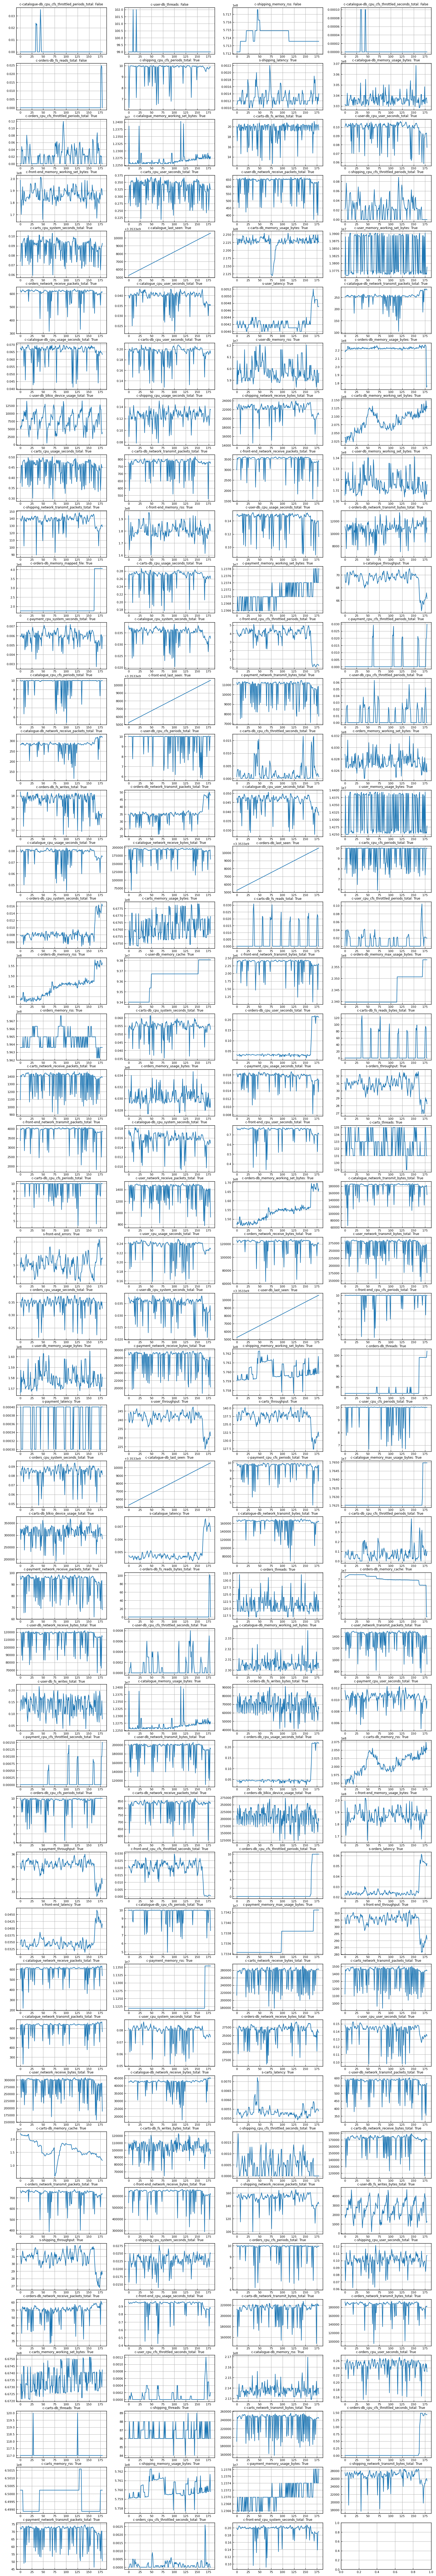

In [20]:
import math

_results_df = results_df.sample(n=min(200, results_df.shape[0]))
ncols = 4
nrows = math.ceil(_results_df.shape[0] / ncols)
fig, axs = plt.subplots(figsize=(20, 2.7 * nrows), nrows=nrows, ncols=ncols)
for (index, data), ax in zip(_results_df.sort_values("is_anomaly").iterrows(), axs.flatten()):  # type: ignore
    ax.plot(data["values"])
    ax.set_title(f"{data['metric']}: {data['is_anomaly']}")